In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer,roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import kds
from imblearn.over_sampling import SMOTE 
import xgboost as xgb

sns.set()

In [2]:
df = pd.read_csv("Preprocessed.csv")

In [3]:
df.head()
asd = pd.DataFrame(df['AcceptedCmp6'].value_counts()).reset_index()
asd['percentage'] = (asd['count']/asd['count'].sum())*100
asd

,AcceptedCmp6,count,percentage
0,0,1734,84.792176
1,1,311,15.207824


### Our Baseline Accuracy should be above 84.79%
But we define our own profit function


In [3]:
X = df.drop(columns="AcceptedCmp6")
y = df["AcceptedCmp6"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Defining Custom Profit Function

In [4]:
sale_revenue = 11
call_cost = 3
false_positive_cost = call_cost

def calculate_profit(y_true, y_pred):
    tn, fp, fn, tp= confusion_matrix(y_true, y_pred).ravel() #tn, fp, fn, tp
    profit_from_sales = tp * (sale_revenue - call_cost)
    loss_from_wasted_calls = fp * false_positive_cost
    total_profit = profit_from_sales - loss_from_wasted_calls
    return total_profit

def profit_scorer(y_true, y_pred):
    return calculate_profit(y_true, y_pred)

scorer = make_scorer(profit_scorer, greater_is_better=True)




## Functions for finding the best thresholds

In [89]:
def evaluate_thresholds(model, X, y_true):
    profits = []
    just_profits = []
    for threshold in thresholds:
        # Get predicted probabilities and convert them to class predictions based on the threshold
        y_prob = model.predict_proba(X)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        # Calculate profit for this threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        profit_from_sales = tp * (sale_revenue - call_cost)
        loss_from_wasted_calls = fp * call_cost
        total_profit = profit_from_sales - loss_from_wasted_calls
        profits.append((threshold, total_profit))
    # Find the best threshold
        just_profits.append(total_profit)
    
    
    best_threshold, best_profit = max(profits, key=lambda x: x[1])
    print(f"Best Threshold: {best_threshold}, Profit: {best_profit}")
    return best_threshold, profits, just_profits

thresholds = np.arange(0.0, 1.01, 0.05)


# Random Forest Classifier 

### Setting up GridSearchCV

In [50]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

param_grid = {
    'n_estimators': [100, 200, 300, 500],  
    'max_depth': [3,4,5,7,9,10,12],   
    'bootstrap': [True, False],  
    'criterion': ['gini', 'entropy']    
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring= scorer)
grid_search_rf.fit(X_train,y_train )


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 7, 9, 10, 12],
                         'n_estimators': [100, 200, 300, 500]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [51]:
best_model_rf = grid_search_rf.best_estimator_
best_model_rf.fit(X_train,y_train)

y_pred_rf_train = best_model_rf.predict(X_train)
y_pred_rf_test = best_model_rf.predict(X_test)


rf_profit_train = profit_scorer(y_train, y_pred_rf_train)
rf_profit_test = profit_scorer(y_test, y_pred_rf_test)

rf_report_train = classification_report(y_train, y_pred_rf_train)
rf_report_test = classification_report(y_test, y_pred_rf_test)


print(f'Profit on training set: {rf_profit_train} \n Profit on test set: {rf_profit_test}')

print(f'Accuracy on training: {rf_report_train} \n Accuracy on test: {rf_report_test}')


Profit on training set: 1091 
 Profit on test set: 348
Accuracy on training:               precision    recall  f1-score   support

           0       0.96      0.91      0.94      1305
           1       0.62      0.78      0.69       228

    accuracy                           0.89      1533
   macro avg       0.79      0.85      0.81      1533
weighted avg       0.91      0.89      0.90      1533
 
 Accuracy on test:               precision    recall  f1-score   support

           0       0.95      0.88      0.91       429
           1       0.55      0.76      0.64        83

    accuracy                           0.86       512
   macro avg       0.75      0.82      0.77       512
weighted avg       0.88      0.86      0.87       512



# Finding the best threshold for maximizing profit

In [ ]:

best_threshold_rf, profit_pairs_rf, profits_rf = evaluate_thresholds(
    model=best_model_rf,
    X=X_test,
    y_true=y_test
    )


rf_probs = best_model_rf.predict_proba(X_test)

Best Threshold: 0.5, Profit: 348


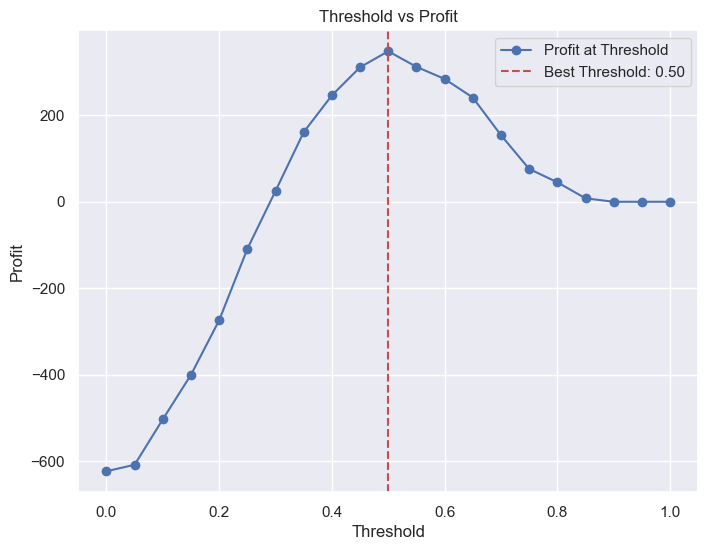

In [97]:



# Plot the threshold-profit pairs
plt.figure(figsize=(8, 6))
plt.plot(thresholds,profits_rf, marker='o', linestyle='-', color='b', label='Profit at Threshold')
plt.axvline(x=best_threshold_rf, color='r', linestyle='--', label=f'Best Threshold: {best_threshold_rf:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Threshold vs Profit')
plt.legend()
plt.grid(True)
plt.show()


## Lift Curve

Purpose: A lift chart shows how much better the model performs compared to random guessing (or a baseline model).  
Calculation: The lift is calculated as the ratio of the model's performance over random guessing.  
>Lift at a particular point = Gain at that point / Random model (random selection) gain at that point   


X-axis: Proportion of data (typically, this is the percentage of the total data that you have ranked by predicted probability, e.g., top 10% of predictions).  
Y-axis: Lift, which shows how much better the model is compared to random chance.


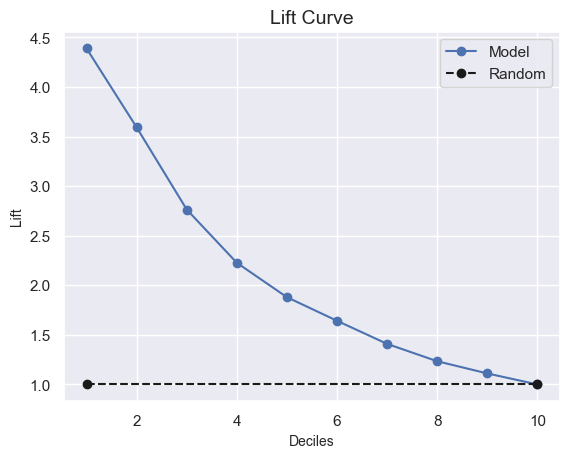

In [98]:
plt.figure()
kds.metrics.plot_lift(y_test, rf_probs[:,1], title="Lift Curve")


### SMOTE - Synthetic Minority Over-sampling Technique

In [99]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [100]:
rf2 = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
    'criterion': ['gini','entropy'],      
    'max_features': ['sqrt','log2']    
    #'bootstrap': [True, False]      --not needed        
}

grid_search_smote = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring= scorer)
grid_search_smote.fit(X_train_sm,y_train_sm )


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [103]:

best_model_rf_smote = grid_search_smote.best_estimator_
best_model_rf_smote.fit(X_train,y_train)

smote_pred_train = best_model_rf_smote.predict(X_train)
smote_pred_test = best_model_rf_smote.predict(X_test)

smote_profit_train = profit_scorer(y_train, smote_pred_train)
smote_profit_test = profit_scorer(y_test, smote_pred_test)

smote_report_train = classification_report(y_train, smote_pred_train)
smote_report_test = classification_report(y_test, smote_pred_test)

print(f'Profit on training set: {smote_profit_train} \n Profit on test set: {smote_profit_test}')

print(f'Accuracy on training: {smote_report_train} \n Accuracy on test: {smote_report_test}')



Profit on training set: 1368 
 Profit on test set: 159
Accuracy on training:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1305
           1       1.00      0.75      0.86       228

    accuracy                           0.96      1533
   macro avg       0.98      0.88      0.92      1533
weighted avg       0.96      0.96      0.96      1533
 
 Accuracy on test:               precision    recall  f1-score   support

           0       0.88      0.97      0.92       429
           1       0.69      0.29      0.41        83

    accuracy                           0.86       512
   macro avg       0.78      0.63      0.66       512
weighted avg       0.85      0.86      0.84       512



In [104]:

best_threshold_smote, profit_pairs_smote, profits_smote = evaluate_thresholds(
    model=best_model_rf_smote,
    X=X_test,
    y_true=y_test,
)

smote_probs =  best_model_rf_smote.predict_proba(X_test)

Best Threshold: 0.30000000000000004, Profit: 319


## XGBoost

In [105]:
xgbclfgs = xgb.XGBClassifier(random_state = 42)

params = { 
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    "gamma":[0, 0.25, 0.5, 0.75,1],
    'n_estimators': [100, 200, 500],
    "subsample":[0.9],
    "colsample_bytree":[0.5],
    "early_stopping_rounds": [10]
}
grid_search_xgb = GridSearchCV(
    estimator = xgbclfgs,
    param_grid = params,
    scoring = scorer,
    n_jobs = -1,
    cv = 5,
)

grid_search_xgb = grid_search_xgb.fit(X_train, y_train,eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.40663
[1]	validation_0-logloss:0.38249
[2]	validation_0-logloss:0.37124
[3]	validation_0-logloss:0.35896
[4]	validation_0-logloss:0.33644
[5]	validation_0-logloss:0.32329
[6]	validation_0-logloss:0.30779
[7]	validation_0-logloss:0.30307
[8]	validation_0-logloss:0.29889
[9]	validation_0-logloss:0.29720
[10]	validation_0-logloss:0.29496
[11]	validation_0-logloss:0.29226
[12]	validation_0-logloss:0.28595
[13]	validation_0-logloss:0.28490
[14]	validation_0-logloss:0.28318
[15]	validation_0-logloss:0.28296
[16]	validation_0-logloss:0.28319
[17]	validation_0-logloss:0.28307
[18]	validation_0-logloss:0.28087
[19]	validation_0-logloss:0.28162
[20]	validation_0-logloss:0.28049
[21]	validation_0-logloss:0.27806
[22]	validation_0-logloss:0.27924
[23]	validation_0-logloss:0.27909
[24]	validation_0-logloss:0.27715
[25]	validation_0-logloss:0.27548
[26]	validation_0-logloss:0.27692
[27]	validation_0-logloss:0.27432
[28]	validation_0-logloss:0.27281
[29]	validation_0-loglos

In [106]:
best_model_xgb = grid_search_xgb.best_estimator_
best_model_xgb.fit(X_train,y_train,eval_set=[(X_test, y_test)])

xgb_pred_train = best_model_xgb.predict(X_train)
xgb_pred_test = best_model_xgb.predict(X_test)

xgb_profit_train = profit_scorer(y_train, xgb_pred_train)
xgb_profit_test = profit_scorer(y_test, xgb_pred_test)

xgb_report_train = classification_report(y_train, xgb_pred_train)
xgb_report_test = classification_report(y_test, xgb_pred_test)

print(f'Profit on training set: {xgb_profit_train} \n Profit on test set: {xgb_profit_test}')

print(f'Accuracy on training: {xgb_report_train} \n Accuracy on test: {xgb_report_test}')


[0]	validation_0-logloss:0.40663
[1]	validation_0-logloss:0.38249
[2]	validation_0-logloss:0.37124
[3]	validation_0-logloss:0.35896


[4]	validation_0-logloss:0.33644
[5]	validation_0-logloss:0.32329
[6]	validation_0-logloss:0.30779
[7]	validation_0-logloss:0.30307
[8]	validation_0-logloss:0.29889
[9]	validation_0-logloss:0.29720
[10]	validation_0-logloss:0.29496
[11]	validation_0-logloss:0.29226
[12]	validation_0-logloss:0.28595
[13]	validation_0-logloss:0.28490
[14]	validation_0-logloss:0.28318
[15]	validation_0-logloss:0.28296
[16]	validation_0-logloss:0.28319
[17]	validation_0-logloss:0.28307
[18]	validation_0-logloss:0.28087
[19]	validation_0-logloss:0.28162
[20]	validation_0-logloss:0.28049
[21]	validation_0-logloss:0.27806
[22]	validation_0-logloss:0.27924
[23]	validation_0-logloss:0.27909
[24]	validation_0-logloss:0.27715
[25]	validation_0-logloss:0.27548
[26]	validation_0-logloss:0.27692
[27]	validation_0-logloss:0.27432
[28]	validation_0-logloss:0.27281
[29]	validation_0-logloss:0.27348
[30]	validation_0-logloss:0.27370
[31]	validation_0-logloss:0.27446
[32]	validation_0-logloss:0.27394
[33]	validation_0-lo

In [108]:
best_threshold_xgb , profits_pairs_xgb, profits_xgb = evaluate_thresholds(best_model_xgb,X_test,y_test)
xgb_probs =  best_model_xgb.predict_proba(X_test)



Best Threshold: 0.2, Profit: 330


# Gradient Boosting Classifier

In [130]:
gb = GradientBoostingClassifier(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 7, 8 ,10],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Perform GridSearchCV
grid_search_gb = GridSearchCV(gb, param_grid, cv=5, scoring=scorer, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 7, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 400],
                         'subsample': [0.8, 1.0]},
             scoring=make_scorer(profit_scorer, response_method='predict'))

In [131]:
best_model_gb = grid_search_gb.best_estimator_
best_model_gb.fit(X_train,y_train)

y_pred_gb_train = best_model_gb.predict(X_train)
y_pred_gb = best_model_gb.predict(X_test)


gb_profit_train = profit_scorer(y_train,y_pred_gb_train)
gb_profit_test = profit_scorer(y_test,y_pred_gb)

gb_report_train = classification_report(y_train, y_pred_gb_train)
gb_report_test = classification_report(y_test, y_pred_gb)

print(f'Profit on training set: {gb_profit_train} \n Profit on test set: {gb_profit_test}')

print(f'Accuracy on training: {gb_report_train} \n Accuracy on test: {gb_report_test}')

Profit on training set: 1764 
 Profit on test set: 270
Accuracy on training:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1305
           1       0.98      0.97      0.98       228

    accuracy                           0.99      1533
   macro avg       0.99      0.99      0.99      1533
weighted avg       0.99      0.99      0.99      1533
 
 Accuracy on test:               precision    recall  f1-score   support

           0       0.91      0.95      0.93       429
           1       0.66      0.51      0.57        83

    accuracy                           0.88       512
   macro avg       0.78      0.73      0.75       512
weighted avg       0.87      0.88      0.87       512



In [132]:
best_threshold_gb, profit_pairs_gb, profits_gb = evaluate_thresholds(
    model=best_model_gb,
    X=X_test,
    y_true=y_test,
)

gb_probs =  best_model_gb.predict_proba(X_test)

Best Threshold: 0.2, Profit: 315


# Comparison of classifiers' threshold-profit pairs

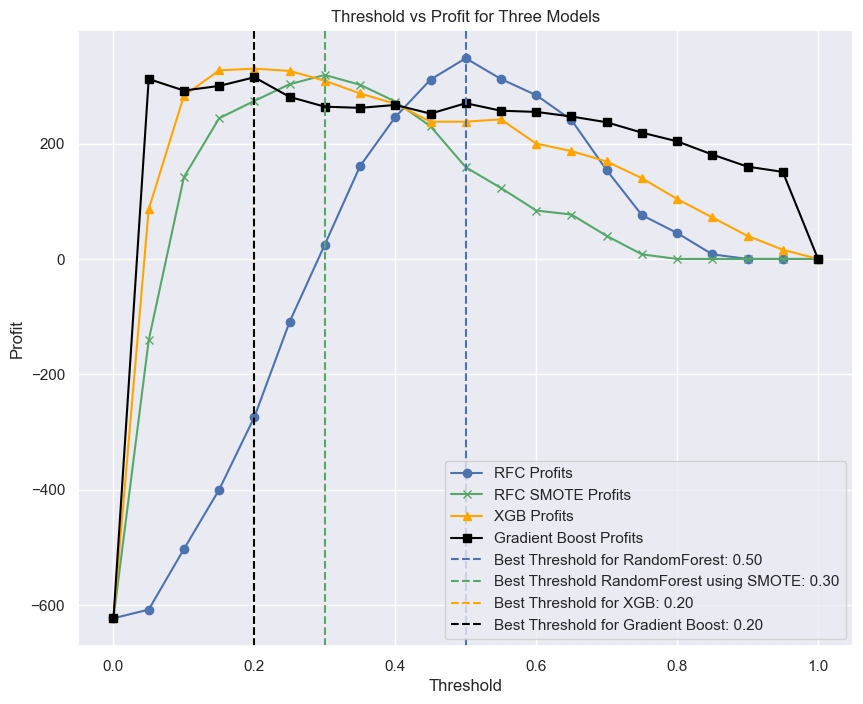

In [133]:

plt.figure(figsize=(10, 8))

plt.plot(thresholds, profits_rf, marker='o', linestyle='-', color='b', label='RFC Profits')

plt.plot(thresholds, profits_smote, marker='x', linestyle='-', color='g', label='RFC SMOTE Profits')

plt.plot(thresholds, profits_xgb, marker='^', linestyle='-', color='orange', label='XGB Profits')

plt.plot(thresholds, profits_gb, marker='s', linestyle='-', color='black', label='Gradient Boost Profits')

# Mark the best threshold for Model 1
plt.axvline(x=best_threshold_rf, color='b', linestyle='--', label=f'Best Threshold for RandomForest: {best_threshold_rf:.2f}')

# Mark the best threshold for Model 2
plt.axvline(x=best_threshold_smote, color='g', linestyle='--', label=f'Best Threshold RandomForest using SMOTE: {best_threshold_smote:.2f}')

# Mark the best threshold for Model 3
plt.axvline(x=best_threshold_xgb, color='orange', linestyle='--', label=f'Best Threshold for XGB: {best_threshold_xgb:.2f}')

plt.axvline(x=best_threshold_gb, color='black', linestyle='--', label=f'Best Threshold for Gradient Boost: {best_threshold_gb:.2f}')

# Labels and title
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Threshold vs Profit for Three Models')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Comparision of ROC curves

## ROC curve

The curve highlights the cost of increasing sensitivity (e.g., catching more true positives) at the expense of specificity (e.g., generating more false positives).

x axis: False Positive rate: Out of the negative instances, how many of them are falsely identified as positives    
y axis: True Positive Rate: Precentage of positive instances identified out of all the positive instances  

#### AUC - Area Under The Curve  
Defines how well the model can distinguish between positive and negative classes.  
>AUC = 1 -> Perfect disrimination  
>AUC = 0.5 -> Model is no better than random guessing

PS: ROC curves can be a good tool when comparing the performance of multiple models

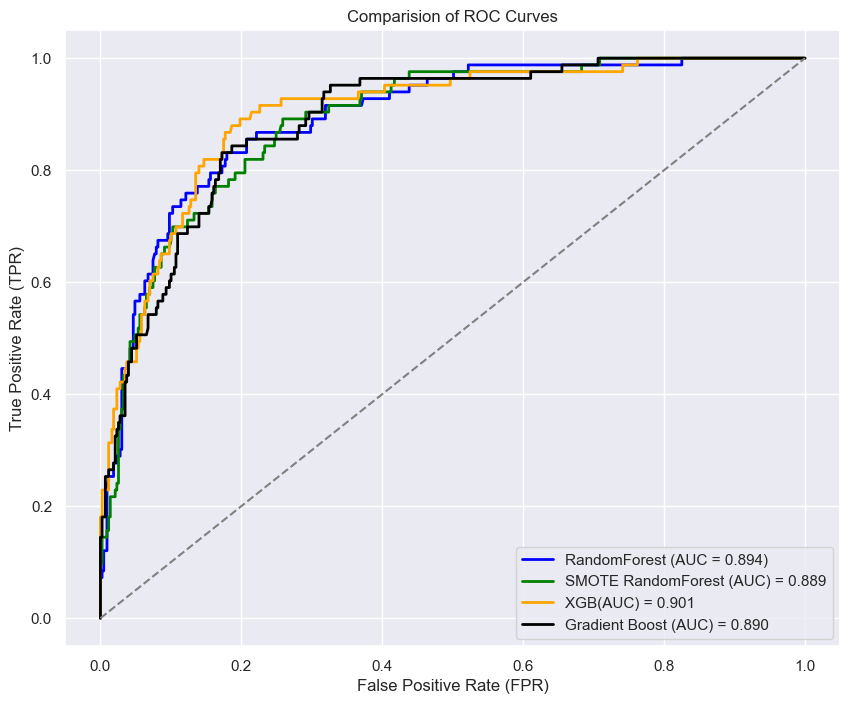

In [134]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs[:,1])
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, smote_probs[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs[:,1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs[:,1])

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_rf_smote = auc(fpr_rf_smote, tpr_rf_smote)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(10,8))

plt.plot(fpr_rf, tpr_rf, color = 'blue', lw=2, label = f'RandomForest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_rf_smote, tpr_rf_smote, color='green', lw = 2, label = f'SMOTE RandomForest (AUC) = {roc_auc_rf_smote:.3f}')
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw = 2, label = f'XGB(AUC) = {roc_auc_xgb:.3f}')
plt.plot(fpr_gb, tpr_gb, color='Black', lw = 2, label = f'Gradient Boost (AUC) = {roc_auc_gb:.3f}')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--') #Random classifiaction

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparision of ROC Curves')

# Add legend
plt.legend(loc='lower right')

# Show plot
plt.grid(True)
plt.show()


# Comparision of Cumulative Gains


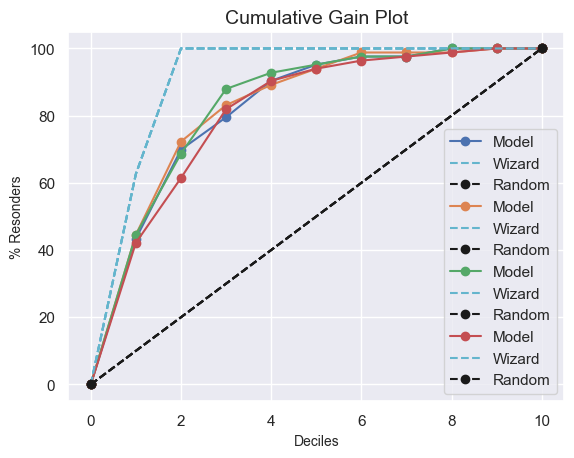

In [126]:
kds.metrics.plot_cumulative_gain(y_test, smote_probs[:,1])
kds.metrics.plot_cumulative_gain(y_test, rf_probs[:,1])
kds.metrics.plot_cumulative_gain(y_test, xgb_probs[:,1])
kds.metrics.plot_cumulative_gain(y_test, gb_probs[:,1])